In [1]:
from src.utils.preprocess_utils import midi_to_one_hot
from src.utils.ml_utils import create_dataloaders, train_model, test_model, plot_metrics
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
import os

In [2]:
# Define dataset
class MidiDataset(Dataset):
    def __init__(self, data_dir, sequence_length=50):
        self.data_dir = data_dir
        self.sequence_length = sequence_length
        self.file_names = [f for f in os.listdir(data_dir) if f.endswith('.mid') or f.endswith('.midi')]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = os.path.join(self.data_dir, file_name)
        
        try:
            data = midi_to_one_hot(file_path)
            
            if data.shape[0] < self.sequence_length:
                raise ValueError(f"File {file_name} is too short for sequence length {self.sequence_length}")
            
            # Pick a random starting index and crop the data to sequence_length
            start_idx = np.random.randint(0, data.shape[0] - self.sequence_length + 1)
            cropped_data = data[start_idx:start_idx + self.sequence_length]

            x = cropped_data[:-1] # Input
            y = cropped_data[1:] # "Label"

            return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
            # If the file is invalid or too short, retry with another random file
            new_idx = np.random.randint(0, len(self.file_names))
            return self.__getitem__(new_idx)

dataset_sequence_length = 60
dataset = MidiDataset(data_dir='data/midis', sequence_length=dataset_sequence_length)

In [3]:
# Get dataloaders with specified params from ml_utils
dataloader_train, dataloader_val, dataloader_test = create_dataloaders(dataset=dataset, batch_size=32, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, shuffle=True)

In [4]:
# Define model architecture
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: [batch_size, sequence_length, input_size]
        out, _ = self.lstm(x)  # out: [batch_size, sequence_length, hidden_size]
        out = self.fc(out)
        return out

input_size = 85  # One-hot size = number of notes
hidden_size = 128  # Size of the hidden state
output_size = 85  # Predict the next note (same size as input)
num_layers = 5 # Number of LSTM layers

model = LSTMModel(input_size, hidden_size, output_size, num_layers)

Error processing Menkveld, Jan Willem, Frech, Op.29 No.21, 4HhMyeQLCTw.mid: File Menkveld, Jan Willem, Frech, Op.29 No.21, 4HhMyeQLCTw.mid is too short for sequence length 60
Error processing Hamilton, Gregory, Roses for Solo Organ, SnCWnkzEurY.mid: File Hamilton, Gregory, Roses for Solo Organ, SnCWnkzEurY.mid is too short for sequence length 60
Error processing Spindler, Fritz, Wellenspiel, Op.6, krXtgqRCAvU.mid: File Spindler, Fritz, Wellenspiel, Op.6, krXtgqRCAvU.mid is too short for sequence length 60
Error processing Antico, Andrea, Per dolor mi bagno, uFY9NWLIpkc.mid: File Antico, Andrea, Per dolor mi bagno, uFY9NWLIpkc.mid is too short for sequence length 60
Error processing Berens, Hermann, 50 Piano Pieces for First Beginners, Op.70, 8I3SZtZHn2s.mid: File Berens, Hermann, 50 Piano Pieces for First Beginners, Op.70, 8I3SZtZHn2s.mid is too short for sequence length 60
Error processing Maylath, Henry, The First Quarter, zUR3bOPQ3b8.mid: File Maylath, Henry, The First Quarter, zUR3

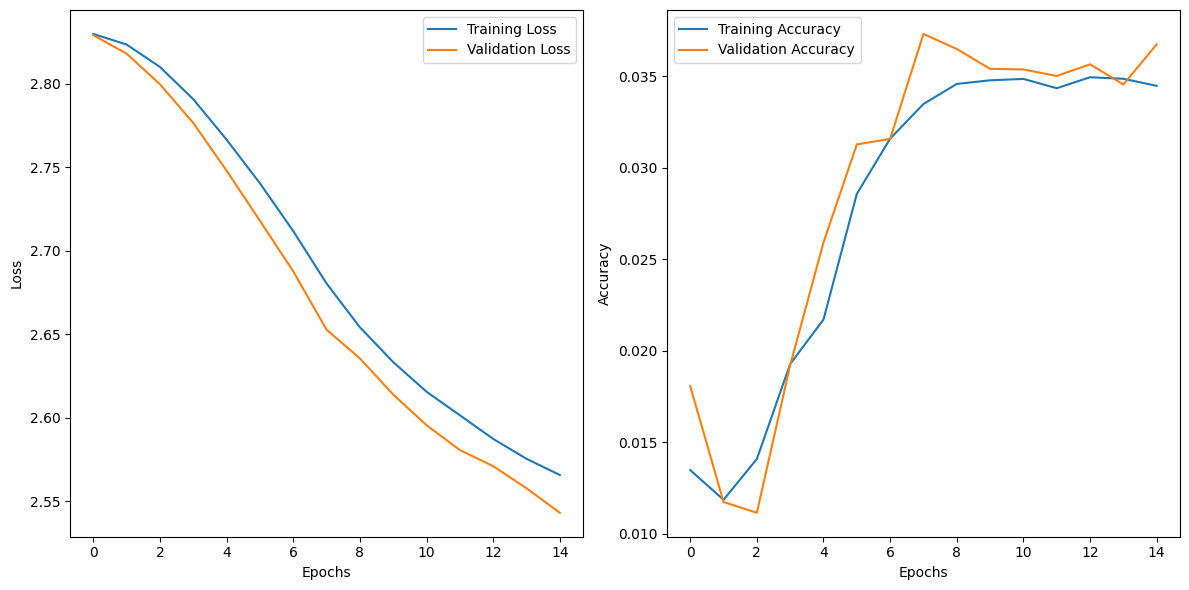

In [5]:
# Train model from ml_utils
best_model, history = train_model(
    model=model,
    dataloaders={"train": dataloader_train, "val": dataloader_val},
    task_type="multiclass",
    n_epochs=15,
    learning_rate=0.001,
    device="cuda"
)
(train_losses, val_losses, train_accuracy, val_accuracy) = history
plot_metrics(train_losses, val_losses, train_accuracy, val_accuracy)

In [6]:
# Test model from ml_utils
test_model(best_model, dataloader_test, nn.CrossEntropyLoss(), task_type="multiclass", device="cuda")

c:\Data\0_ELTE\!_Tárgyak\2024-25_1\MNAF\beadando\piano-midi-generation\.venv\lib\site-packages\torch\nn\modules\rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1410.)
  result = _VF.lstm(


Error processing Stahl, William C., Golden Bell Waltz, gmrKI53VUVQ.mid: File Stahl, William C., Golden Bell Waltz, gmrKI53VUVQ.mid is too short for sequence length 60
Test metrics - Loss: 2.5481, Accuracy: 0.0369


(np.float64(2.548120045194439), np.float64(0.036920846677293964))

In [7]:
# Save model
from datetime import datetime

timestamp = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
filename = f'weights/model_1/{timestamp}_h{hidden_size}_l{num_layers}_sl{dataset_sequence_length}'

torch.save(best_model, filename)